# Pipeline 
In this notebook I'll try to fix the pipeline

In [1]:
import os
import argparse
import pickle
import os.path 
import pandas as pd
import numpy as np
from tqdm import tqdm
from benchtools.src.clustering import build_features
from benchtools.src.datatools import separate_data
from math import ceil
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

# Importing the classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from benchtools.src.metrictools import optimal_threshold, rejection_plot, inverse_roc_plot, significance_plot, precision_recall_plot

## Getting the data

I'll pre-process the data using the <code>benchtools</code> package. The next cell just need to be ran one time

In [2]:
#build_features(path_data='..\..\events_anomalydetection.h5', nbatch=10, outname='test', chunksize=10000)

In [3]:
df_RD = pd.read_csv("..\data\\test.csv").drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
df_RD.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,deltaR_j12,n_hadrons,label
0,1286.727685,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,0.064989,0.393688,1287.481934,0.713248,33,3.159663,109.0,0.0
1,1354.394070,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,-0.874319,-1.786248,1916.370744,0.276881,97,3.581406,208.0,0.0
2,1214.955723,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,0.143831,-1.090330,1089.530630,0.726963,59,3.149348,196.0,0.0
3,1285.227873,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,0.294854,-0.322661,1285.618789,0.706361,89,3.298155,183.0,0.0
4,1210.415787,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,1.060534,0.264977,1772.340209,0.787662,57,3.629229,169.0,1.0


In [6]:
df_RD.shape

(100000, 15)

In [4]:
# Importing the data 
#df = pd.read_csv("..\data\RD_dataset.csv")
#df.head()

Since this is not the complete comparison I'll use a smaller dataset to avoid running into memory issues. I'll also eliminate the columns of mass to make the training as model-free as possible

In [5]:
#df_RD = df.sample(100000, random_state = 1).drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
#df_RD.head()

## Defining functions and global variables
First I'll define the list of pre-selected algorithms based on the results of notebook 4, 8 and 13

The algorithms need the training features and the labels separated

In [7]:
# Separating the features from the label
X, y = separate_data(df_RD, standarize=False)
# Splitting in training and testis sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [8]:
# Classifier class to save the output

class classifier:
    def __init__(self, name, score, pred, label):
        self.name = name
        self.score = score
        self.pred = pred       
        self.label = label
    #def numeric_metrics()
        
    def rejection(self):
        rejection_plot(self.name, self.label, self.score)
        plt.show()
        
    def inverse_roc(self):
        inverse_roc_plot(self.name, self.label, self.score)
        plt.show()
    
    def significance(self):
        significance_plot(self.name, self.label, self.score)
        plt.show()
        
    def precision_recall(self):
        precision_recall_plot(self.name, self.label, self.score)
        plt.show()

In [10]:
# Tensorflow classifier
def TensorflowClassifier(input_shape):

    # Creating the model
    # Here are the layers with batch normalization, the drop out rate and the activations
    
    model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
    ])

    # Choosing the optimizer
    # Binary crossentropy for binary classification
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],)
    
    return model

In [18]:
# Training and evaluation functions
def training_pipeline(X_train, y_train, X_test, y_test, classifiers, dimension_reduction=None):
    
    models = []

    for scaler, clf in tqdm(classifiers):
        
        name = clf.__class__.__name__

        if name == 'Sequential' :
            name = 'TensorflowClassifier'
            # Scaling the data
            X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
            X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])
            # Getting model
            model = clf
            model.summary()
            # We use early stop to prevent the model from overfitting
            early_stopping = keras.callbacks.EarlyStopping(
                patience=20,
                min_delta=0.001,
                restore_best_weights=True,
            )
            # Training the model
            model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            batch_size=512,
            epochs=200,
            callbacks=[early_stopping])
  
            model.save('../../data/tf_model.h5')

        # For tensorflow the training is different
        else:
            # Simple pipeline
            if dimension_reduction is None:
                model = Pipeline(steps=[('ss', scaler), ('clf', clf)])
            else:
                model = Pipeline(steps=[('ss', scaler), ('dr', dimension_reduction), ('clf', clf)])

            # Training the model  
            fit = model.fit(X_train, y_train) 

            # Saving into a list
            models.append((name,fit))

            # Saving into a pickle file
            with open("sklearn_models_log.pckl", "wb") as f:
                for model in models:
                    pickle.dump(model, f)
            print('Models saved') 
    

def evaluate_pipeline(X_test, y_test, models):
   # To save the output
    clfs = []
    
    for name, model in tqdm(models):
        
        if name != 'TensorflowClassifier':
            # Getting the prediction
            y_pred = model.predict(X_test)
            
            # Probability or distances
            try: 
                y_score = model.predict_proba(X_test)

                clfs.append(classifier(name, y_score[:,1], y_pred, y_test))
            except: 
                # KMeans doesn't have a probability, so here we get 
                # the distances to each cluster
                y_score = model.transform(X_test)
                # The score for KMeans is defined differently
                norm = np.linalg.norm(y_score[:,1])
                clfs.append(classifier(name, 1-y_score[:,1]/norm, y_pred, y_test))
        
        # For tensorflow the prediction is done differently
        else:
            y_score = model.predict(X_test)
            # Getting the threshold to make class predictions (0 or 1)
            threshold = optimal_threshold(y_test, y_score)
            y_pred = (model.predict(X_test) > threshold).astype("int32")
            clfs.append(classifier(name, y_score, y_pred, y_test))
    
    return clfs

In [19]:
# Listing the classifiers to compare
classifiers = [(StandardScaler(), RandomForestClassifier(random_state=1)),
                (RobustScaler(), GradientBoostingClassifier(random_state=4)),
                (RobustScaler(), QuadraticDiscriminantAnalysis()), 
                ]

## Training the algorithms and comparing
First, we use the function to train the algorithms and get the scores and predictions

In [20]:
training_pipeline(X_train, y_train, X_test, y_test, classifiers)

 33%|███▎      | 1/3 [00:21<00:43, 21.74s/it]

Models saved


 67%|██████▋   | 2/3 [01:16<00:41, 41.12s/it]

Models saved


100%|██████████| 3/3 [01:16<00:00, 25.65s/it]

Models saved


In [22]:
models = []
with open("sklearn_models_log.pckl", "rb") as f:
    while True:
        try:
            models.append(pickle.load(f))
        except EOFError:
            break

In [23]:
models

[('RandomForestClassifier',
  Pipeline(steps=[('ss', StandardScaler()),
                  ('clf', RandomForestClassifier(random_state=1))])),
 ('GradientBoostingClassifier',
  Pipeline(steps=[('ss', RobustScaler()),
                  ('clf', GradientBoostingClassifier(random_state=4))])),
 ('QuadraticDiscriminantAnalysis',
  Pipeline(steps=[('ss', RobustScaler()),
                  ('clf', QuadraticDiscriminantAnalysis())]))]

In [10]:
clfs = evaluate_pipeline(X_test, y_test, models_file)

100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


In [11]:
names = [clf.name for clf in clfs]
scores = [clf.score for clf in clfs]
preds = [clf.pred for clf in clfs]      
labels = [clf.label.to_numpy() for clf in clfs]

names

['RandomForestClassifier',
 'GradientBoostingClassifier',
 'QuadraticDiscriminantAnalysis',
 'MLPClassifier',
 'KMeans',
 'TensorflowClassifier']

And check that the data is saved as expected: a dictionary were each key is the name of the algorithm and for each key an array with the scores or predictions

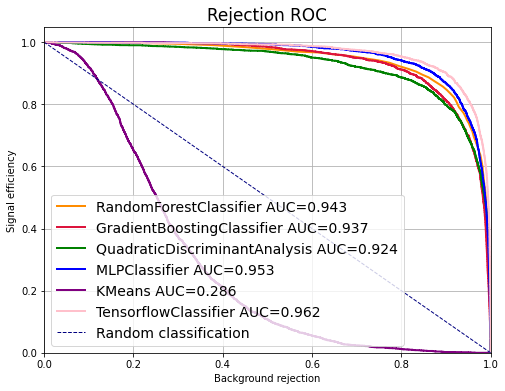

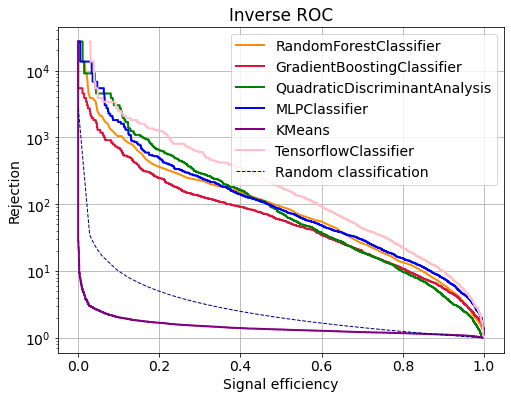

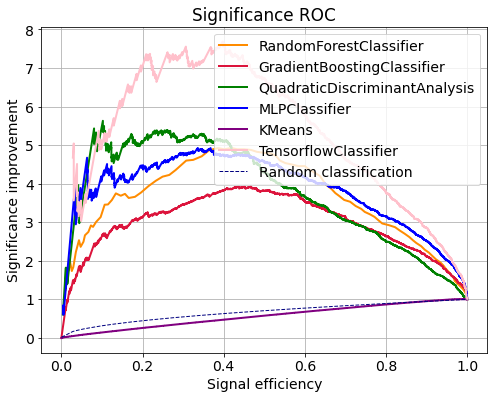

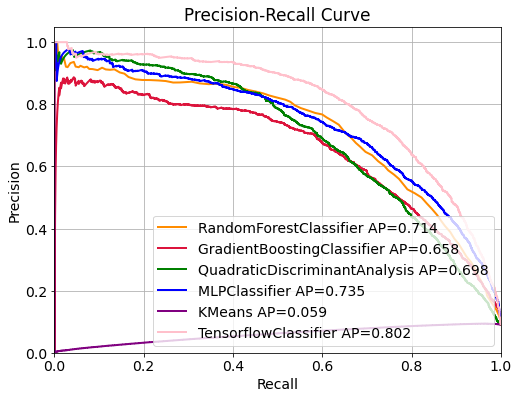

In [12]:
from benchtools.src.metrictools import performance_metrics, rejection_plot, inverse_roc_plot, significance_plot, precision_recall_plot

rejection_plot(names=names, labels=labels, probs=scores)
plt.savefig('rejection6.png', bbox_inches='tight')

inverse_roc_plot(names=names, labels=labels, probs=scores)
plt.savefig('inverse6.png', bbox_inches='tight')

significance_plot(names=names, labels=labels, probs=scores)
plt.savefig('significance6.png', bbox_inches='tight')

precision_recall_plot(names=names, labels=labels, probs=scores)
plt.savefig('precision6.png', bbox_inches='tight')

In [ ]:
from benchtools.src.plotools import bkg_sig_hist

In [ ]:
df_test = pd.read_csv("..\data\\test.csv")
features = df_test.drop('label', axis=1).columns.tolist()

In [ ]:
df_RD = df.sample(100000, random_state = 1)

In [ ]:
for feature in features:
    bkg_sig_hist(df_RD, variable=feature, label='label')
    bkg_sig_hist(df_test, variable=feature, label='label')
    plt.show()